In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import json
import networkx as nx
import copy

def load_data_from_file(filename):
    """
    Load a dictionary of graphs from JSON file.
    """
    with open(filename, "r") as file_handle:
        string_dict = json.load(file_handle)
    return _load_data_from_string_dict(string_dict)

def load_data_from_string(json_string):
    """
    Load a dictionary of graphs from JSON string.
    """
    string_dict = json.loads(json_string)
    return _load_data_from_string_dict(string_dict)

def _load_data_from_string_dict(string_dict):
    result_dict = {}
    for key in string_dict:

        data = copy.deepcopy(string_dict[key])

        if 'edges' in data:
            data["links"] = data.pop("edges")

        graph = nx.node_link_graph(data)
        result_dict[key] = graph
    return result_dict

def write_data_to_json_string(graph_dict, **kwargs):
    """
    Write dictionary of graphs to JSON string.
    """
    json_string = json.dumps(graph_dict, default=nx.node_link_data, **kwargs)
    return json_string


def write_data_to_json_file(graph_dict, filename, **kwargs):
    """
    Write dictionary of graphs to JSON file.
    """
    with open(filename, "w") as file_handle:
        file_handle.write(write_data_to_json_string(graph_dict, **kwargs))

First, load unique data points

In [4]:
train_data = load_data_from_file("/content/drive/My Drive/GNN-hack/graph_data.json") # dictionary of SMILES and values are graphs
embeddings = pd.read_csv('/content/drive/My Drive/GNN-hack/final_embedding_dim30.csv')

/usr/local/lib/python3.11/dist-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.
  warnings.warn(


In [5]:
# Embedding IDs
embedded_atoms = list(embeddings['Atoms'])
embedded_orbitals = list(embeddings['Orbital'])

embedded_IDs = [a+','+o for a,o in zip(embedded_atoms, embedded_orbitals)]

# Embedding vectors
embedded_vectors = []

for i in range(len(embeddings)):
  a = list(np.fromstring(embeddings.loc[i,'Embeddings'].replace('\n','').strip('[]'), sep=' '))
  if len(a)>31: # Noble gas elements?
    a = list(a[-31:])

  embedded_vectors.append(a)

In [6]:
embedded_IDs.index('Co,3p')

60

In [7]:
# get all the unique atom types, orbitals and their respective binding energies

atoms = []
charges = []
orbs = []
energies = []


for mol in train_data:
    graph = train_data[mol]

    atom = list(nx.get_node_attributes(graph, "atom_type").values())
    charge = list(nx.get_node_attributes(graph, "formal_charge").values())
    orb = list(nx.get_node_attributes(graph, "orbitals").values())
    energy = list(nx.get_node_attributes(graph, "binding_energies").values())

    for i in range(len(orb)):
        for j in range(len(orb[i])):
            if energy[i][j]!=-1:
                atoms.append(atom[i])
                charges.append(charge[i])
                orbs.append(orb[i][j])
                energies.append(energy[i][j])

# Also get embedding vectors for each species, if embedding exists
ids = [a+','+o for a,o in zip(atoms, orbs)]

states = []

for i in range(len(ids)):
  id = ids[i]
  if id in embedded_IDs:
    states.append(embedded_vectors[embedded_IDs.index(id)])
  else:
    states.append([0]*31)

Encode these data points, both atomic number and quantum numbers for orbitals

In [8]:
atom_dict = {
 'Li': 3,
 'B': 5,
 'C': 6,
 'N': 7,
 'O': 8,
 'F': 9,
 'Ne': 10,
 'Na': 11,
 'Mg': 12,
 'Al': 13,
 'Si': 14,
 'P': 15,
 'S': 16,
 'Cl': 17,
 'Ar': 18,
 'K': 19,
 'Ca': 20,
 'Ti': 22,
 'V': 23,
 'Cr': 24,
 'Mn': 25,
 'Fe': 26,
 'Co': 27,
 'Ni': 28,
 'Cu': 29,
 'Zn': 30,
 'Ga': 31,
 'Ge': 32,
 'As': 33,
 'Se': 34,
 'Br': 35,
 'Kr': 36,
 'Rb': 37,
 'Sr': 38,
 'Mo': 42,
 'Rh': 45,
 'Ag': 47,
 'Cd': 48,
 'In': 49,
 'Sn': 50,
 'Sb': 51,
 'Te': 52,
 'I': 53,
 'Xe': 54,
 'Cs': 55,
 'Ba': 56,
 'W': 74,
 'Re': 75,
 'Hg': 80,
 'Tl': 81,
 'Pb': 82,
 'Bi': 83,
 'U': 92
}

orb_dict = {
 '2p': [2, 1, 0],
 '2p3/2': [2, 1, 1.5],
 '4p3/2': [4, 1, 1.5],
 '3d5/2': [3, 2, 2.5],
 '3d': [3, 2, 0],
 '5p3/2': [5, 1, 1.5],
 '2s': [2, 0, 0],
 '1s': [1, 0, 0],
 '4s': [4, 0, 0],
 '3p': [3, 1, 0],
 '5d5/2': [5, 2, 2.5],
 '5s': [5, 0, 0],
 '3s': [3, 0, 0],
 '3p3/2': [3, 1, 1.5],
 '4d5/2': [4, 2, 2.5],
 '4d': [4, 2, 0],
 '4f7/2': [4, 3, 3.5]
}

In [9]:
data = []

for i in range(len(atoms)):
    atom = atoms[i]
    charge = charges[i]
    orb = orbs[i]
    energy = energies[i]

    atomic_number = atom_dict[atom]
    q_numbers = orb_dict[orb]

    state = states[i]

    data.append([atomic_number]+[charge]+q_numbers+state+[energy])

data = np.array(data)

In [10]:
data.shape

(5192, 37)

Let us split into training and testing sets

In [11]:
data_train, data_test = train_test_split(data, train_size=0.8)
data_train = np.float64(data_train)
data_test = np.float64(data_test)

First, the training - let us split into input and output vectors

In [12]:
X_train = data_train[:,:-1]
y_train = data_train[:,-1]
y_train = y_train.reshape(-1, 1)

In [14]:
# Define the MLP model
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size=64, output_size=1, dropout_rate=0.2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.leaky_relu(x, 0.1)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.leaky_relu(x, 0.1)
        x = self.fc3(x)
        return x

In [15]:
# Model parameters
input_size = 36
hidden_size = 64
output_size = 1
batch_size = 8
learning_rate = 1e-5
num_epochs = 200

In [16]:
# Instantiate the model
model = MLP(input_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [17]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [18]:
num_epochs = 100
batch_size = 16

In [19]:
# Split training data into train and validation
X_train_actual, X_val, y_train_actual, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

In [20]:
# Create datasets and dataloaders
train_dataset = TensorDataset(
    torch.tensor(X_train_actual, dtype=torch.float32),
    torch.tensor(y_train_actual, dtype=torch.float32)
)
val_dataset = TensorDataset(
    torch.tensor(X_val, dtype=torch.float32),
    torch.tensor(y_val, dtype=torch.float32)
)

In [21]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [22]:
# Training loop with validation
best_val_loss = float('inf')
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = F.mse_loss(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            val_loss += F.mse_loss(outputs, targets).item()

    val_loss /= len(val_loader)

    # Learning rate adjustment
    scheduler.step(val_loss)

    # Print metrics and save best model
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), '/content/drive/My Drive/GNN-hack/best_model_emb.pt')

Epoch 10/100: Train Loss: 45727.8581, Val Loss: 45622.2264
Epoch 20/100: Train Loss: 20088.5110, Val Loss: 21683.2174
Epoch 30/100: Train Loss: 16289.3647, Val Loss: 15938.0398
Epoch 40/100: Train Loss: 13703.5397, Val Loss: 14193.0475
Epoch 50/100: Train Loss: 12032.1201, Val Loss: 11941.0984
Epoch 60/100: Train Loss: 10778.0596, Val Loss: 10379.9301
Epoch 70/100: Train Loss: 9410.2281, Val Loss: 8210.5982
Epoch 80/100: Train Loss: 7827.3310, Val Loss: 6930.1901
Epoch 90/100: Train Loss: 6753.7339, Val Loss: 5683.5758
Epoch 100/100: Train Loss: 6730.3433, Val Loss: 5743.3317


Evaluate model predictions on test set

In [23]:
X_test = data_test[:,:-1]

In [24]:
# Minimal batch prediction approach
# Kernel dies in the simplest approach

# Set model to evaluation mode
model.eval()

# Define a reasonable batch size
batch_size = 16

# Create empty array for predictions
num_samples = X_test.shape[0]
y_pred_test = np.zeros((num_samples, 1))

# Process in batches
for i in range(0, num_samples, batch_size):
    end_idx = min(i + batch_size, num_samples)
    batch_X = X_test[i:end_idx]

    # Convert to tensor, ensure float type
    batch_tensor = torch.tensor(batch_X, dtype=torch.float32)

    # Make prediction with no gradient tracking
    with torch.no_grad():
        y_pred_test[i:end_idx] = model(batch_tensor).numpy()

# Get actual test values and evaluate
y_test = data_test[:, -1].reshape(-1, 1)

In [25]:
np.mean((y_test-y_pred_test)**2)

np.float64(4077.4652965402624)

Text(0, 0.5, '$y_\\mathrm{pred}-y_\\mathrm{test}$ (Binding energy)')

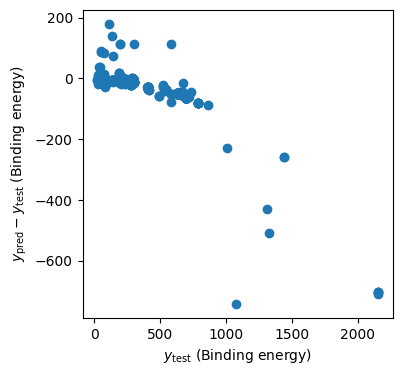

In [28]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.scatter(y_test, y_pred_test-y_test)
ax.set_xlabel(r'$y_\mathrm{test}$ (Binding energy)')
ax.set_ylabel(r'$y_\mathrm{pred}-y_\mathrm{test}$ (Binding energy)')